<a href="https://colab.research.google.com/github/Xuan-He-97/Neural-networks-and-quantum-field-theory/blob/main/Experiments/Chapter3/3_5_NNNGP_Correlations_in_Gauss_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pickle
import pathlib
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import quad
from tqdm import tqdm

In [ ]:
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
Ns = [2, 3, 4, 5, 10, 20, 50, 100, 500, 1000]

In [ ]:
X_Gauss = np.array([[-0.01], [-0.006], [-0.002], [0.002], [0.006], [0.01]])

### Find all distinct combination of $G^{(n)}$

In [ ]:
def findsubsets(X, n):
    res = []
    for i1 in range(n+1):
        for i2 in range(n+1-i1):
            for i3 in range(n+1-i1-i2):
                for i4 in range(n+1-i1-i2-i3):
                    for i5 in range(n+1-i1-i2-i3-i4):
                        i6 = n-i1-i2-i3-i4-i5
                        res.append([X[0]]*i1 + [X[1]]*i2 + [X[2]]*i3 + [X[3]]*i4 + [X[4]]*i5 + [X[5]]*i6)
    return res

In [ ]:
comb2 = findsubsets([i for i in range(6)], 2)
print(len(comb2))
comb4 = findsubsets([i for i in range(6)], 4)
print(len(comb4))
comb6 = findsubsets([i for i in range(6)], 6)
print(len(comb6))

21
126
462


### $\Delta_{1234y}$

In [ ]:
def integrand4(t, x1, x2, x3, x4, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t)

### $\int d^{d_{in}}y \; \Delta_{1234y}$

In [ ]:
def compute_integral4(X, comb, K, Lambda, integrand=integrand4):
    res = []
    for c in comb:
        x1, x2, x3, x4 = X[c]
        res.append(quad(integrand, -Lambda, Lambda, args=(x1, x2, x3, x4, K))[0])
    return dict(zip([tuple(c) for c in comb], res))

### $\Delta_{1234,y,56}$

In [ ]:
def integrand6(t, x1, x2, x3, x4, x5, x6, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t) * K(x5, x6)

### $\Sigma\int d^{d_{in}}y \; \Delta_{1234,y,56}$

In [ ]:
def compute_integral6(X, comb, K, Lambda, integrand=integrand6):
    res = []
    wick_pairs24 = [[1, 2, 3, 4, 5, 6], [1, 3, 2, 4, 5, 6], [1, 4, 2, 3, 5, 6], [1, 5, 2, 3, 4, 6], [1, 6, 2, 3, 4, 5], 
                    [2, 3, 1, 4, 5, 6], [2, 4, 1, 3, 5, 6], [2, 5, 1, 3, 4, 6], [2, 6, 1, 3, 4, 5], [3, 4, 1, 2, 5, 6], 
                    [3, 5, 1, 2, 4, 6], [3, 6, 1, 2, 4, 5], [4, 5, 1, 2, 3, 6], [4, 6, 1, 2, 3, 5], [5, 6, 1, 2, 3, 4]]
    for c in comb:
        inte = 0
        for idx in wick_pairs24:
            idx = [i-1 for i in idx]
            x1, x2, x3, x4 = X[c][idx[2:]]
            x5, x6 = X[c][idx[:2]]
            inte += quad(integrand, -Lambda, Lambda, args=(x1, x2, x3, x4, x5, x6, K))[0]
        res.append(inte)
    return dict(zip([tuple(c) for c in comb], res))

## Gauss-net

### Gauss-net $K(x_i, x_j)$ and $K_W(x_i, x_j)$

In [ ]:
def K_Gauss(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    return sigmab2 + sigmaw2 * np.exp(-sigmaw2 * np.square(x - y) / (2.0*d_in))

In [ ]:
def Kw_Gauss(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    return sigmaw2 * np.exp(-sigmaw2 * np.square(x - y) / (2.0*d_in))

### Compute $\int d^{d_{in}}y \; \Delta_{1234y}$

In [ ]:
%%time
integral4_Gauss = compute_integral4(X_Gauss.reshape(-1), comb4, Kw_Gauss, np.inf)

CPU times: user 607 ms, sys: 0 ns, total: 607 ms
Wall time: 617 ms


### Compute $\Sigma\int d^{d_{in}}y \; \Delta_{1234,y,56}$

In [ ]:
%%time
integral6_Gauss = compute_integral6(X_Gauss.reshape(-1), comb6, Kw_Gauss, np.inf)

CPU times: user 39.9 s, sys: 64.5 ms, total: 39.9 s
Wall time: 40 s


### Compute $K_W(x_i, x_j)$ and save the results

In [ ]:
def compute_K(X, comb, K):
    K_values = []
    for c in comb:
        x1, x2 = X[c]
        K_values.append(K(x1, x2))
    return dict(zip([tuple(c) for c in comb], K_values))

In [ ]:
K_values = compute_K(X_Gauss.reshape(-1), comb2, K_Gauss)

In [ ]:
K_values

{(0, 0): 2.0,
 (0, 1): 1.999992000032,
 (0, 2): 1.9999680005119944,
 (0, 3): 1.999928002591938,
 (0, 4): 1.9998720081916503,
 (0, 5): 1.9998000199986667,
 (1, 1): 2.0,
 (1, 2): 1.999992000032,
 (1, 3): 1.9999680005119944,
 (1, 4): 1.999928002591938,
 (1, 5): 1.9998720081916503,
 (2, 2): 2.0,
 (2, 3): 1.999992000032,
 (2, 4): 1.9999680005119944,
 (2, 5): 1.999928002591938,
 (3, 3): 2.0,
 (3, 4): 1.999992000032,
 (3, 5): 1.9999680005119944,
 (4, 4): 2.0,
 (4, 5): 1.999992000032,
 (5, 5): 2.0}

### Wick contraction

In [ ]:
def G_gp2(X, K):
    x1, x2 = X
    return K(x1, x2)

In [ ]:
def G_gp4(X, K):
    x1, x2, x3, x4 = X
    return K(x1, x2) * K(x3, x4) + K(x1, x3) * K(x2, x4) + K(x1, x4) * K(x2, x3)

In [ ]:
def G_gp6(X, K):
    wick_pairs = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 4, 6], [1, 2, 3, 6, 4, 5], [1, 3, 2, 4, 5, 6], [1, 3, 2, 5, 4, 6],
                  [1, 3, 2, 6, 4, 5], [1, 4, 2, 3, 5, 6], [1, 4, 2, 5, 3, 6], [1, 4, 2, 6, 3, 5], 
                  [1, 5, 2, 3, 4, 6], [1, 5, 2, 4, 3, 6],
                  [1, 5, 2, 6, 3, 4], [1, 6, 2, 3, 4, 5], [1, 6, 2, 4, 3, 5], [1, 6, 2, 5, 3, 4]]
    res = 0
    for x1, x2, x3, x4, x5, x6 in wick_pairs:
        res += K(X[x1-1], X[x2-1]) * K(X[x3-1], X[x4-1]) * K(X[x5-1], X[x6-1])
    return res

### Compute $G_{GP}^{(6)}$

In [ ]:
G_gp6_Gauss = []
for c in comb6:
    G_gp6_Gauss.append(G_gp6(X_Gauss.reshape(-1)[c], K_Gauss))
G_gp6_Gauss = dict(zip([tuple(c) for c in comb6], G_gp6_Gauss))

### Load experimental $G^{(4)}$ and $G^{(6)}$ result and compute $\lambda_m$

In [ ]:
dir = '/gdrive/MyDrive/NNGP/Gauss/'
files = list(pathlib.Path(dir).glob('*'))
lambdam4_Gauss = []
lambdam6_Gauss = []
G4_Gauss = []
G6_Gauss = []
for file in tqdm(files):
    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            B = 24 * integral4_Gauss[tuple(c)]
            G4 = fx_exp[:, c].prod(1).mean()
            lambdam4_Gauss.append((A - G4) / B)
            G4_Gauss.append(G4)
        for c in comb6: 
            A = G_gp6_Gauss[tuple(c)]
            B = 24 * integral6_Gauss[tuple(c)]
            G6 = fx_exp[:, c].prod(1).mean()
            lambdam6_Gauss.append((A - G6) / B)
            G6_Gauss.append(G6)

100%|██████████| 10/10 [51:13<00:00, 307.37s/it]


### Plot $\lambda_{m4}$ 

In [ ]:
lambdam4_Gauss_df = pd.DataFrame(np.log10(np.abs(lambdam4_Gauss).reshape(10, -1)))
lambdam4_Gauss_df.index = np.log10(Ns)

In [ ]:
lambdam4_Gauss_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0.301030,0.440796,0.440807,0.440823,0.440843,0.440868,0.440815,0.440836,0.440861,0.440890,0.440853,0.440883,0.440917,0.440910,0.440949,0.440986,0.440821,0.440846,0.440876,0.440910,0.440869,0.440903,0.440942,0.440935,0.440979,0.441020,0.440889,0.440928,0.440971,0.440964,0.441012,0.441058,0.440998,0.441051,0.441102,0.441150,0.440825,0.440854,0.440889,0.440928,0.440881,...,0.441058,0.441121,0.441181,0.441238,0.440947,0.441001,0.441058,0.441051,0.441114,0.441173,0.441099,0.441166,0.441231,0.441293,0.441145,0.441216,0.441286,0.441353,0.441417,0.440972,0.441029,0.441092,0.441085,0.441152,0.441216,0.441137,0.441209,0.441278,0.441345,0.441187,0.441264,0.441338,0.441410,0.441479,0.441235,0.441316,0.441395,0.441471,0.441545,0.441617
0.477121,0.166251,0.166324,0.166402,0.166484,0.166571,0.166395,0.166477,0.166564,0.166656,0.166557,0.166649,0.166745,0.166738,0.166839,0.166937,0.166463,0.166550,0.166642,0.166738,0.166634,0.166731,0.166831,0.166824,0.166930,0.167033,0.166716,0.166817,0.166923,0.166916,0.167026,0.167133,0.167011,0.167126,0.167238,0.167348,0.166529,0.166620,0.166716,0.166817,0.166709,...,0.167196,0.167319,0.167441,0.167560,0.166962,0.167076,0.167196,0.167189,0.167312,0.167434,0.167298,0.167427,0.167553,0.167676,0.167405,0.167538,0.167669,0.167797,0.167923,0.167048,0.167167,0.167291,0.167284,0.167412,0.167538,0.167398,0.167531,0.167662,0.167790,0.167510,0.167648,0.167783,0.167916,0.168046,0.167619,0.167762,0.167901,0.168039,0.168174,0.168306
0.602060,0.180641,0.180227,0.179817,0.179411,0.179009,0.179810,0.179404,0.179002,0.178604,0.178995,0.178597,0.178203,0.178196,0.177806,0.177413,0.179390,0.178988,0.178590,0.178196,0.178583,0.178189,0.177799,0.177792,0.177406,0.177016,0.178175,0.177785,0.177398,0.177391,0.177009,0.176624,0.176995,0.176617,0.176235,0.175851,0.178967,0.178569,0.178175,0.177785,0.178168,...,0.176193,0.175822,0.175449,0.175072,0.176945,0.176567,0.176193,0.176185,0.175815,0.175442,0.175801,0.175435,0.175065,0.174693,0.175413,0.175051,0.174686,0.174317,0.173946,0.176538,0.176164,0.175794,0.175787,0.175420,0.175051,0.175406,0.175044,0.174678,0.174310,0.175022,0.174664,0.174303,0.173938,0.173571,0.174636,0.174282,0.173924,0.173564,0.173200,0.172834
0.698970,0.040915,0.041069,0.041230,0.041398,0.041572,0.041223,0.041391,0.041565,0.041745,0.041558,0.041738,0.041926,0.041919,0.042113,0.042307,0.041376,0.041551,0.041731,0.041919,0.041724,0.041912,0.042106,0.042099,0.042300,0.042500,0.041898,0.042092,0.042293,0.042285,0.042493,0.042700,0.042479,0.042693,0.042907,0.043120,0.041529,0.041710,0.041898,0.042092,0.041890,...,0.042864,0.043092,0.043320,0.043547,0.042429,0.042644,0.042864,0.042857,0.043085,0.043312,0.043071,0.043305,0.043540,0.043773,0.043284,0.043525,0.043766,0.044007,0.044247,0.042615,0.042836,0.043064,0.043057,0.043291,0.043525,0.043277,0.043518,0.043759,0.044000,0.043497,0.043745,0.043993,0.044240,0.044488,0.043717,0.043972,0.044226,0.044480,0.044735,0.044988
1.000000,-0.264648,-0.264662,-0.264670,-0.264672,-0.264668,-0.264677,-0.264679,-0.264675,-0.264665,-0.264682,-0.264672,-0.264655,-0.264662,-0.264640,-0.264619,-0.264693,-0.264689,-0.264679,-0.264662,-0.264686,-0.264669,-0.264647,-0.264654,-0.264626,-0.264598,-0.264683,-0.264661,-0.264632,-0.264639,-0.264605,-0.264571,-0.264619,-0.264578,-0.264538,-0.264500,-0.264710,-0.264700,-0.264683,-0.264661,-0.264690,...,-0.264580,-0.264528,-0.264476,-0.264425,-0.264668,-0.264627,-0.264580,-0.264587,-0.264535,-0.264483,-0.264549,-0.264490,-0.264432,-0.264375,-0.264511,-0.264446,-0.264382,-0.264319,-0.264257,-0.264655,-0.264608,-0.264556,-0.264563,-0.264504,-0.264446,-0.264518,-0.264453,-0.264389,-0.264326,-0.264474,-0.264403,-0.264333,-0.264264,-0.264196,-0.264431,-0.264354,-0.264278,-0.264203,-0.264129,-0.2

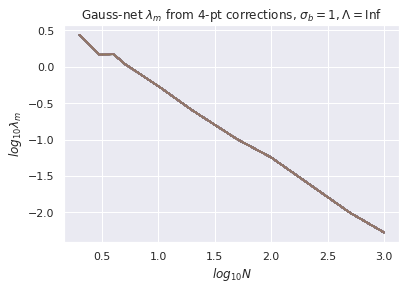

In [ ]:
ax = lambdam4_Gauss_df.plot(legend=False)
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}\lambda_m$")
plt.title("Gauss-net $\lambda_m$ from 4-pt corrections, $\sigma_b=1, \Lambda=$Inf")
plt.show()

### Plot $\lambda_{m6}$ 

In [ ]:
lambdam6_Gauss_df = pd.DataFrame(np.log10(np.abs(lambdam6_Gauss).reshape(10, -1)))
lambdam6_Gauss_df.index = np.log10(Ns)

In [ ]:
lambdam6_Gauss_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461
0.301030,2.842061,2.841693,2.841328,2.840964,2.840602,2.840243,2.839886,2.841320,2.840957,2.840595,2.840236,2.839878,2.839523,2.840588,2.840229,2.839871,2.839516,2.839163,2.839864,2.839509,2.839156,2.838805,2.839149,2.838798,2.838449,2.838442,2.838095,2.837744,2.840942,2.840581,2.840221,2.839864,2.839509,2.839156,2.840214,2.839857,2.839502,2.839149,2.838798,2.839494,...,2.834531,2.834210,2.833884,2.833553,2.835181,2.834855,2.834531,2.834524,2.834203,2.833877,2.834188,2.833870,2.833546,2.833218,2.833848,2.833532,2.833210,2.832885,2.832554,2.834826,2.834502,2.834181,2.834174,2.833855,2.833532,2.833841,2.833524,2.833203,2.832877,2.833503,2.833189,2.832870,2.832547,2.832219,2.833160,2.832848,2.832532,2.832211,2.831886,2.831555
0.477121,1.881669,1.881757,1.881849,1.881944,1.882042,1.882143,1.882248,1.881842,1.881937,1.882035,1.882136,1.882241,1.882349,1.882028,1.882129,1.882234,1.882342,1.882454,1.882227,1.882335,1.882447,1.882562,1.882440,1.882555,1.882673,1.882666,1.882788,1.882906,1.881923,1.882021,1.882122,1.882227,1.882335,1.882447,1.882116,1.882220,1.882328,1.882440,1.882555,1.882322,...,1.883977,1.884137,1.884293,1.884445,1.883669,1.883822,1.883977,1.883971,1.884130,1.884286,1.884116,1.884279,1.884438,1.884594,1.884258,1.884424,1.884587,1.884746,1.884902,1.883794,1.883950,1.884109,1.884102,1.884265,1.884424,1.884251,1.884417,1.884580,1.884739,1.884397,1.884566,1.884733,1.884895,1.885055,1.884539,1.884712,1.884882,1.885048,1.885211,1.885370
0.602060,2.561743,2.560621,2.559500,2.558379,2.557258,2.556137,2.555016,2.559493,2.558372,2.557251,2.556130,2.555009,2.553888,2.557244,2.556123,2.555002,2.553881,2.552760,2.554995,2.553874,2.552753,2.551632,2.552746,2.551625,2.550504,2.550497,2.549376,2.548248,2.558358,2.557237,2.556116,2.554995,2.553874,2.552753,2.556109,2.554988,2.553867,2.552746,2.551625,2.553860,...,2.537951,2.536831,2.535704,2.534571,2.540191,2.539071,2.537951,2.537944,2.536824,2.535697,2.536810,2.535690,2.534564,2.533430,2.535669,2.534549,2.533423,2.532289,2.531149,2.539043,2.537923,2.536803,2.536796,2.535676,2.534549,2.535662,2.534542,2.533416,2.532282,2.534521,2.533401,2.532275,2.531142,2.530001,2.533373,2.532254,2.531127,2.529994,2.528854,2.527707
0.698970,1.890360,1.890666,1.890979,1.891301,1.891631,1.891969,1.892315,1.890972,1.891294,1.891624,1.891962,1.892308,1.892663,1.891617,1.891955,1.892302,1.892656,1.893019,1.892295,1.892649,1.893012,1.893382,1.893005,1.893376,1.893755,1.893748,1.894135,1.894524,1.891280,1.891610,1.891948,1.892295,1.892649,1.893012,1.891942,1.892288,1.892642,1.893005,1.893376,1.892635,...,1.898264,1.898746,1.899230,1.899716,1.897326,1.897791,1.898264,1.898257,1.898739,1.899223,1.898725,1.899216,1.899709,1.900204,1.899195,1.899695,1.900197,1.900700,1.901206,1.897763,1.898236,1.898718,1.898711,1.899202,1.899695,1.899188,1.899688,1.900190,1.900693,1.899667,1.900176,1.900687,1.901199,1.901714,1.900148,1.900666,1.901186,1.901707,1.902231,1.902758
1.000000,1.472913,1.473351,1.473794,1.474243,1.474697,1.475157,1.475622,1.473787,1.474236,1.474691,1.475150,1.475616,1.476087,1.474684,1.475144,1.475609,1.476080,1.476556,1.475603,1.476073,1.476550,1.477031,1.476543,1.477025,1.477512,1.477505,1.477998,1.478489,1.474223,1.474677,1.475137,1.475603,1.476073,1.476550,1.475131,1.475596,1.476067,1.476543,1.477025,1.476060,...,1.483011,1.483562,1.484110,1.484658,1.481926,1.482466,1.483011,1.483005,1.483555,1.484104,1.483542,1.484097,1.484651,1.485204,1.484078,1.484638,1.485197,1.485755,1.486311,1.482440,1.482985,1.483535,1.483529,1.484084,1.484638,1.484071,1.484632,1.485191,1.485748,1.484612,1.485178,1.485742,1.486304,1.486865,1.485151,1.485722,1.486291,1.486859,1.487425,1.487989
1.301030,0.663505,0.663608,0.663713,0.663821,0.663931,0.6640

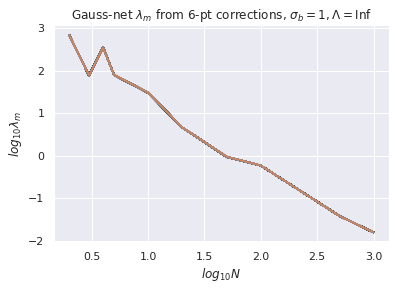

In [ ]:
ax = lambdam6_Gauss_df.plot(legend=False)
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}\lambda_m$")
plt.title("Gauss-net $\lambda_m$ from 6-pt corrections, $\sigma_b=1, \Lambda=$Inf")
plt.show()

In [ ]:
idx = -1

In [ ]:
GP_pred = np.array(list(G_gp6_Gauss.values())) / np.array(G6_Gauss).reshape(10, -1)[idx, :]

In [ ]:
GP_lambda_pred = (np.array(list(G_gp6_Gauss.values())) - 24 * np.array(lambdam4_Gauss).reshape(10, -1)[idx, :].mean() * np.array(list(integral6_Gauss.values()))) / np.array(G6_Gauss).reshape(10, -1)[idx, :]

In [ ]:
GP_pred_df = pd.DataFrame(np.expand_dims(GP_pred, axis=0), columns=[r"$G^{(6)}_{GP}$/$G^{(6)}$"]*GP_pred.shape[-1])
GP_lambda_pred_df = pd.DataFrame(np.expand_dims(GP_lambda_pred, axis=0), 
                                 columns=[r"($G^{(6)}_{GP} + \bar{\lambda}$ contribution)/$G^{(6)}$"]*GP_lambda_pred.shape[-1])

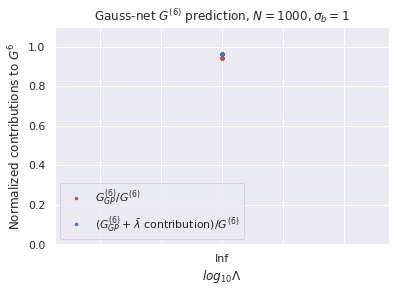

In [ ]:

colors = ['r']*GP_pred.shape[-1] + ['b']*GP_pred.shape[-1]
concated_df = pd.concat([GP_pred_df, GP_lambda_pred_df], axis=1)
concated_df.index = ['Inf']
ax = concated_df.plot(color=colors, legend=False, style='.', markersize=5)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
ax.set_ylim([0.0, 1.1])
plt.xlabel("$log_{10}\Lambda$")
plt.ylabel("Normalized contributions to $G^6$")
plt.title("Gauss-net $G^{(6)}$ prediction, $N=1000, \sigma_b=1$")
plt.show()